In [6]:
%run 2_panel_creation/header_data_treatment.ipynb

In [99]:
works_au_af = spark.read.format('parquet').load('file:\\' + openalex_path + 'works_au_af.parquet')


In [104]:
#works_au_af.filter(func.col('author_id')=='A5084984675').select(func.col('publication_year').alias('year'), 'inst_id','inst_type').distinct().sort('year').collect()

In [7]:
df_scanR = spark.read.format('parquet').load('file:\\' + scanR_path + 'publications.parquet')

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/D:/scanR/publications.parquet.

In [3]:
df_scanR.printSchema()

NameError: name 'df_scanR' is not defined

In [3]:
df_inst_scanR = spark.read.option("multiline","true").json('file:\\' + scanR_path + 'organizations.json')

In [45]:
public_labs = spark.read.option("multiline","true").json('file:\\' + scanR_path + 'fr-esr-structures-recherche-publiques-actives.json')
public_labs.printSchema()

root
 |-- adresse: string (nullable = true)
 |-- annee_d_effet_historique: string (nullable = true)
 |-- annee_de_creation: string (nullable = true)
 |-- code_de_nature_de_tutelle: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- code_de_niveau_de_structure: string (nullable = true)
 |-- code_de_type_de_structure: string (nullable = true)
 |-- code_de_type_de_succession: string (nullable = true)
 |-- code_de_type_de_tutelle: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- code_domaine_scientifique: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- code_panel_erc: string (nullable = true)
 |-- code_postal: string (nullable = true)
 |-- commune: string (nullable = true)
 |-- domaine_scientifique: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fiche_rnsr: string (nullable = true)
 |-- label_numero: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- li

In [58]:
public_labs.select(func.explode(func.col('nature_de_tutelle')).alias('nature_de_tutelle')).distinct().collect()

[Row(nature_de_tutelle='Université'),
 Row(nature_de_tutelle='Fondation et institut particulier (Institut pasteur, Institut Curie, etc.)'),
 Row(nature_de_tutelle='Etablissement public à caractère administratif'),
 Row(nature_de_tutelle='Organismes de type EPST'),
 Row(nature_de_tutelle='Société de droit privé étrangère'),
 Row(nature_de_tutelle='Etablissements de santé'),
 Row(nature_de_tutelle='Université étrangère'),
 Row(nature_de_tutelle='Opérateur public étranger'),
 Row(nature_de_tutelle='Organismes de type EPIC'),
 Row(nature_de_tutelle='Autres établissements ESR'),
 Row(nature_de_tutelle='Société de droit privé française'),
 Row(nature_de_tutelle='Autre opérateur de droit étranger'),
 Row(nature_de_tutelle='Site'),
 Row(nature_de_tutelle='Autre opérateur de droit français')]

In [46]:
all_labs = spark.read.option("multiline","true").json('file:\\' + scanR_path + 'fr-esr-repertoire-national-structures-recherche.json')
all_labs.printSchema()

root
 |-- annee_de_creation: string (nullable = true)
 |-- annee_de_fermeture: string (nullable = true)
 |-- annee_de_succession: string (nullable = true)
 |-- code_de_niveau_de_structure: string (nullable = true)
 |-- code_de_type_de_structure: string (nullable = true)
 |-- code_de_type_de_succession: string (nullable = true)
 |-- etat: string (nullable = true)
 |-- libelle: string (nullable = true)
 |-- numero_de_structure_successeur: string (nullable = true)
 |-- numero_national_de_structure: string (nullable = true)
 |-- sigle: string (nullable = true)
 |-- type_de_structure: string (nullable = true)
 |-- type_de_succession: string (nullable = true)



In [49]:
all_labs.withColumnRenamed('numero_national_de_structure', 'id').join(df_inst_scanR
          .select('id', func.lit(1).alias('in_scanR'))
          , on = ['id'], how = 'anti')x.select('libelle').collect()

[Row(libelle='VOIR ET ENTENDRE FONDATION'),
 Row(libelle='GEM Recherche'),
 Row(libelle="Ecole française d'Extrême-Orient"),
 Row(libelle='Institut Max Von Laue - Paul Langevin'),
 Row(libelle='Hôpital de Hautepierre'),
 Row(libelle='European Molecular Biology Laboratory'),
 Row(libelle="Institut français d'archéologie orientale du Caire"),
 Row(libelle='Sciences Analytiques pour le Patrimoine'),
 Row(libelle="Ecole d'économie de Paris"),
 Row(libelle="AGENCE DE L'ENVIRONNEMENT ET DE LA MAITRISE DE L'ENERGIE"),
 Row(libelle="Gestion de l'Institut Carnot ICEEL de Nancy"),
 Row(libelle='Compréhension mathématique multi-échelles d’écosystèmes vivants complexes avec structures émergentes'),
 Row(libelle="Concevoir des technologies d'amélioration de la vie privée explicables et efficaces"),
 Row(libelle='ARVALIS - Institut du végétal'),
 Row(libelle='Acta-les instituts techniques agricoles'),
 Row(libelle='Hôpitaux de Saint-Maurice'),
 Row(libelle='DRCI du CHU de Reims'),
 Row(libelle='Syst

In [110]:
all_labs.printSchema()

root
 |-- annee_de_creation: string (nullable = true)
 |-- annee_de_fermeture: string (nullable = true)
 |-- annee_de_succession: string (nullable = true)
 |-- code_de_niveau_de_structure: string (nullable = true)
 |-- code_de_type_de_structure: string (nullable = true)
 |-- code_de_type_de_succession: string (nullable = true)
 |-- etat: string (nullable = true)
 |-- libelle: string (nullable = true)
 |-- numero_de_structure_successeur: string (nullable = true)
 |-- numero_national_de_structure: string (nullable = true)
 |-- sigle: string (nullable = true)
 |-- type_de_structure: string (nullable = true)
 |-- type_de_succession: string (nullable = true)



In [114]:
(all_labs
 .select('numero_national_de_structure', func.lit(1).alias('in_all_labs'), "annee_de_fermeture").join(
    public_labs.select('numero_national_de_structure',func.lit(1).alias('in_public_labs')), on =['numero_national_de_structure'], how ='full')
 .groupBy(func.col('annee_de_fermeture').isNull().alias('active'), 'in_all_labs', 'in_public_labs').count()).show()

+------+-----------+--------------+-----+
|active|in_all_labs|in_public_labs|count|
+------+-----------+--------------+-----+
| false|          1|             1|  230|
|  true|          1|          NULL|    2|
|  true|          1|             1| 4395|
| false|          1|          NULL| 7193|
+------+-----------+--------------+-----+



In [119]:
(all_labs
 .select('numero_national_de_structure', func.lit(1).alias('in_all_labs'), "annee_de_fermeture",'libelle').join(
    public_labs.select('numero_national_de_structure',func.lit(1).alias('in_public_labs')), on =['numero_national_de_structure'], how ='full')
 .filter((func.col('annee_de_fermeture').isNull()) & (func.col('in_public_labs').isNull()) )).collect()

[Row(numero_national_de_structure='202224138W', in_all_labs=1, annee_de_fermeture=None, libelle=';', in_public_labs=None),
 Row(numero_national_de_structure='202224139X', in_all_labs=1, annee_de_fermeture=None, libelle='.', in_public_labs=None)]

In [130]:
[row[0] for row in df_scanR.select('type').distinct().collect()]

['these',
 'proceedings',
 'other',
 'preprint',
 'thesis',
 'book-chapter',
 'book',
 'journal-article',
 None]

# test stats desc type UR

In [131]:
test_desc = (df_scanR
             .withColumn('authors', func.explode(func.col('authors')))
             .withColumn('af', func.explode(func.col('authors.affiliations')))
             .withColumn('idref', func.regexp_replace(func.lower(func.col("authors.person")), 'idref',''))
             .withColumn('idref', func.when(func.col('idref').isNull(), func.col('authors.fullName')).otherwise(func.col('idref')))
             .select('id','idref','af', 'type','year').distinct()
             .join(all_labs.select(func.col('numero_national_de_structure').alias('af'), 'type_de_structure'), on =['af'], how = 'inner')
             .groupBy('af', 'year','type_de_structure')
             .agg( *[func.sum( (func.col('type')==type).cast('int')).alias('nr_' + type) for type in ['these', 'proceedings', 'other', 'preprint', 'thesis',
                                                                                                       'book-chapter', 'book', 'journal-article']],
                 func.countDistinct('idref').alias('nr_authors')
                 )
            ) 

test_desc.show()
print(test_desc.select('af').distinct().count())

+----------+----+--------------------+--------+--------------+--------+-----------+---------+---------------+-------+------------------+----------+
|        af|year|   type_de_structure|nr_these|nr_proceedings|nr_other|nr_preprint|nr_thesis|nr_book-chapter|nr_book|nr_journal-article|nr_authors|
+----------+----+--------------------+--------+--------------+--------+-----------+---------+---------------+-------+------------------+----------+
|200120109H|2019|         Unité mixte|       0|             0|      22|          0|        0|              0|      0|               168|        80|
|201923268N|2012|        Unité propre|       5|             1|       0|          0|        0|              0|      0|                72|        60|
|200818245B|2022|Structures Fédéra...|      35|           286|     227|          0|        0|             20|      7|               265|       264|
|198319352N|2012|         Unité mixte|       0|           205|      24|          0|        0|             30|   

In [163]:
test_desc_pd = (test_desc
                .groupBy('type_de_structure','year')
                .agg( *[func.mean(col).alias(col.replace('nr_','')) for col in test_desc.columns if 'nr_' in col],
                     *[func.sum(col).alias('total_' + col.replace('nr_','')) for col in test_desc.columns if 'nr_' in col],
                     *[func.percentile_approx(col, 0.5).alias('med_' + col.replace('nr_','')) for col in test_desc.columns if 'nr_' in col]
                    )
               ).toPandas()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Users\rapha\anaconda3\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rapha\anaconda3\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rapha\anaconda3\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rapha\anaconda3\Lib\site-packages\py4j\clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sen

ConnectionRefusedError: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée

In [ ]:
type_structure = sorted(list(set(test_desc_pd['type_de_structure'])))
test_desc_pd['test_desc_pd']= pd.Categorical(test_desc_pd['type_de_structure'], type_structure)

In [138]:

import seaborn as sns 
import matplotlib as mlt
import matplotlib.pyplot as plt
from itertools import cycle, islice

SINGLE_PLOT_SIZE=(10,8)

def graph_2(df, x, y):
    sns.set_theme(style='white')
    fig,ax=plt.subplots(1,figsize=SINGLE_PLOT_SIZE)
    sns.lineplot(
        data=df,
        x=x, y=y, 
        legend = False,
        estimator = None
    )
    #plt.axvline(2018, color="firebrick", linestyle='--',linewidth = 0.75)
    #plt.axvline(2015, color="darkseagreen", linestyle='--',linewidth = 0.75)
      # Background color
    fig.set_facecolor("white")
      # Y-axis
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([round(x, 4) for x in current_values])
    plt.ylabel('', fontsize=14,loc='center',labelpad=10)

    # X-axis
    plt.xlabel('Year', fontsize=14,loc='center',labelpad=10)

    # Title
    #fig.suptitle(col_dict_titles[y], fontsize=14)
     
    fig.suptitle(y, fontsize=14)

    for year in year_of_change:
        plt.axvline(year, color="firebrick", linestyle='--', linewidth=0.75)
    # Box
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

      # Legend
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.5,-0.43),
    )
    fig.tight_layout()
    

def graph_3(df, x, y, categorical, values_cat):
    sns.set_theme(style='white')
    custom_colors = ['seagreen', 'steelblue', "darkseagreen", 'lightsteelblue','midnightblue','grey','goldenrod','burlywood','peru']
    fig,ax=plt.subplots(1,figsize=SINGLE_PLOT_SIZE)
    sns.lineplot(
        data=df,
        x=x, y=y, hue = categorical,
        palette = ['firebrick'] +list(islice(cycle(custom_colors), None, len(values_cat)-1)),
        legend = False,
        estimator = None
    )
    #plt.axvline(2018, color="firebrick", linestyle='--',linewidth = 0.75)
    #plt.axvline(2015, color="darkseagreen", linestyle='--',linewidth = 0.75)
      # Background color
    fig.set_facecolor("white")
      # Y-axis
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([round(x, 4) for x in current_values])
    plt.ylabel('', fontsize=14,loc='center',labelpad=10)

    # X-axis
    plt.xlabel('Year', fontsize=14,loc='center',labelpad=10)

    # Title
    #fig.suptitle(col_dict_titles[y], fontsize=14)
     
    fig.suptitle(y, fontsize=14)

    for year in year_of_change:
        plt.axvline(year, color="firebrick", linestyle='--', linewidth=0.75)
    # Box
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

      # Legend
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.5,-0.43),
        ncol=3,
        labels = values_cat
    )
    fig.tight_layout()
    


In [ ]:
test_desc_pd = test_desc_pd[test_desc_pd['year'].isin(range(1980,2023))]

In [ ]:
year_of_change =[2007 ]
graph_3(test_desc_pd, 'year', 'authors', 'type_de_structure', type_structure)

In [161]:
agg_desc_stats = (df_scanR
                  .filter(func.col('year').between(1990,2023))
                  .withColumn('type', func.when(func.col('type').isNull(), 'null').otherwise(func.col('type')))
                  .withColumn('type', func.concat_ws(',', func.col('productionType'), func.col('type')))
             .groupBy('year','type')
             .agg(
                  func.countDistinct('id').alias('nr_doc')
                 )
            ).toPandas()
types = sorted(list(set(agg_desc_stats['type'] )))
agg_desc_stats['type'] = pd.Categorical(agg_desc_stats['type'], types)

C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
C:\Users\rapha\AppData\Local\Temp\ipykernel_20364\1568416090.py:65: UserWarning: set_ticklabels() should only be used with a fixed n

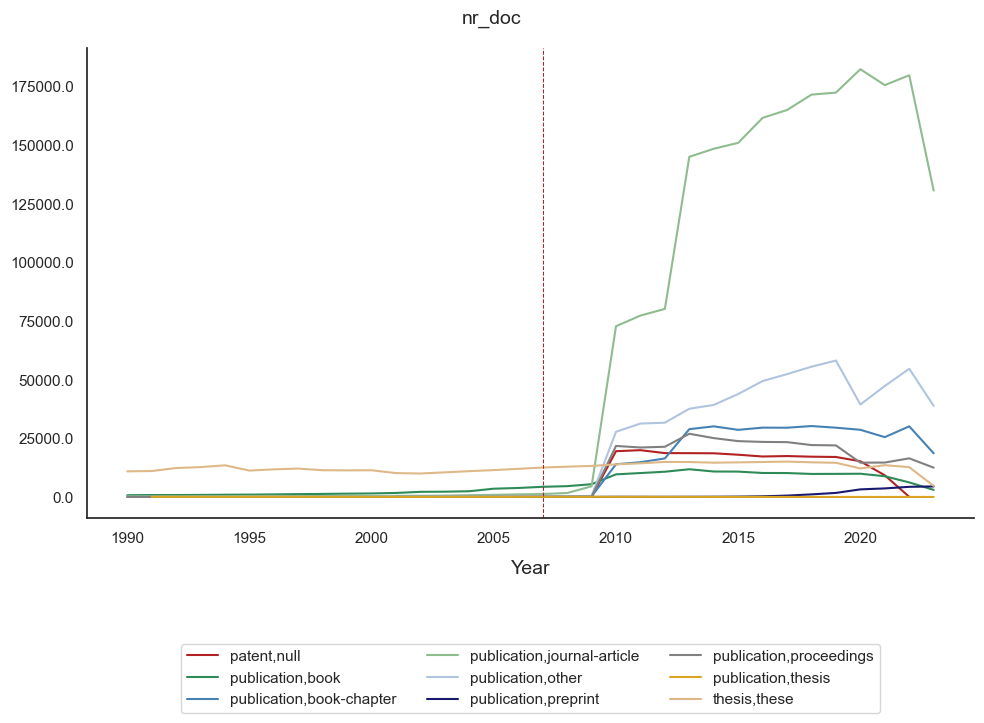

In [162]:
graph_3(agg_desc_stats, 'year', 'nr_doc','type', types)

In [24]:
from pymarc import MARCReader
import pymarc
import urllib.parse
import requests 

text = requests.get('https://www.idref.fr/OAI/oai.jsp?verb=ListRecords&metadataPrefix=marc21&set=a')

In [26]:
text.text

'<?xml version=\'1.0\' encoding=\'UTF-8\'?><OAI-PMH xmlns=\'http://www.openarchives.org/OAI/2.0/\' xmlns:xsi= \'http://www.w3.org/2001/XMLSchema-instance\' xsi:schemaLocation=\'http://www.openarchives.org/OAI/2.0/ http://www.openarchives.org/OAI/2.0/OAI-PMH.xsd\'><responseDate>2024:06:25T13:31:51Z</responseDate><request verb="ListRecords" metadataPrefix="marc21" set="a">https://www.idref.fr/OAI/oai.jsp</request>\t<ListRecords>\t\t<record>\t\t\t<header>\t\t<identifier>oai:IdRefOAIServer.fr:026647745</identifier>\t\t<datestamp>2020-04-14T03:41:26Z</datestamp>\t\t\t<setSpec>a</setSpec>\t\t</header>\t\t\t<metadata>\t<marc:collection xmlns:marc=\'http://www.loc.gov/MARC21/slim\' ><record>\n   <leader>     cz  a22     oc 4500</leader>\n   <controlfield tag="001">026647745</controlfield>\n   <controlfield tag="005">20200414034126.0</controlfield>\n   <controlfield tag="008">840705 |fazz|||a||          || ||a     d</controlfield>\n   <datafield tag="024" ind1="7" ind2=" ">\n      <subfield cod

In [25]:
reader = pymarc.marcxml.parse_xml(text.text, 'marc')
for record in reader:
    print(record)

URLError: <urlopen error unknown url type: ?xml version='1.0' encoding='utf-8'?><oai-pmh xmlns='http>

# Accuracy

In [4]:
test_acc = (df_scanR
             .withColumn('authors', func.explode(func.col('authors')))
             .withColumn('af', func.explode(func.col('authors.affiliations')))
             .withColumn('idref', func.regexp_replace(func.lower(func.col("authors.person")), 'idref',''))
             .filter( func.col('authors.fullName')== 'Philippe Aghion')
             .withColumn('idref', func.when(func.col('idref').isNull(), func.col('authors.fullName')).otherwise(func.col('idref')))
             .select('id','idref','af', 'type','year').distinct()
            ) 
test_acc.cache()
test_acc.sort('year').collect()

NameError: name 'df_scanR' is not defined